### Data Loading and Initial Exploration
We'll analyze the Credit Risk Benchmark dataset from Kaggle, which provides a rich set of features for predicting loan defaults:

**Financial Metrics**:
- `rev_util`: Revolving utilization rate (total credit used / total credit limit)
- `debt_ratio`: Total monthly debt payments / total monthly income
- `monthly_inc`: Monthly income in dollars

**Payment History** (key default indicators):
- `late_30_59`: Number of payments 30-59 days late
- `late_60_89`: Number of payments 60-89 days late
- `late_90`: Number of payments 90+ days late

**Credit Profile**:
- `open_credit`: Number of open credit lines
- `real_estate`: Number of real estate loans or lines

**Demographics**:
- `age`: Borrower's age in years
- `dependents`: Number of dependents (excluding spouse)

**Target Variable**:
- `dlq_2yrs`: Binary indicator (1 = defaulted within 2 years, 0 = did not default)

This diverse feature set allows us to examine both financial behavior and personal characteristics that may influence default risk.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub


c:\Users\max3l\Documents\seng474\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Quality Assessment

Our initial data quality analysis reveals these characteristics:

**Data Structure**:
- Dataset contains 16,714 records with 11 features
- All columns are stored as float64 type, including the binary target

**Data Completeness**:
- No missing values in any column (100% complete)
- Only 2 duplicate records identified 
- Target variable (`dlq_2yrs`) is well-balanced

**Value Ranges and Distributions**:
- `rev_util`: Extremely wide range (0 to 22,000), suggesting potential outliers
- `age`: Reasonable range (21 to 101 years), roughly normal distribution
- `monthly_inc`: $0 to $250,000, heavily right-skewed
- `debt_ratio`: Some extreme values up to ~61,000, likely requiring treatment
- `Late payment variables`: Zero-inflated with long right tails

**Preprocessing Needs**:
1. Handle extreme outliers in financial variables
2. Consider log transformation for heavily skewed features
3. Remove or flag duplicate records
4. Standardize numeric features for modeling


In [25]:
""" Download the dataset for kaggle and print the first 5 rows """
path = kagglehub.dataset_download("adilshamim8/credit-risk-benchmark-dataset")

if os.path.exists(path):
  print("Path to dataset files:", os.listdir(path))
else:
  print("File does not exist")

df = pd.read_csv(os.path.join(path, "Credit Risk Benchmark Dataset.csv"))
print(df.head())



Path to dataset files: ['Credit Risk Benchmark Dataset.csv']
   rev_util   age  late_30_59  debt_ratio  monthly_inc  open_credit  late_90  \
0  0.006999  38.0         0.0    0.302150       5440.0          4.0      0.0   
1  0.704592  63.0         0.0    0.471441       8000.0          9.0      0.0   
2  0.063113  57.0         0.0    0.068586       5000.0         17.0      0.0   
3  0.368397  68.0         0.0    0.296273       6250.0         16.0      0.0   
4  1.000000  34.0         1.0    0.000000       3500.0          0.0      0.0   

   real_estate  late_60_89  dependents  dlq_2yrs  
0          1.0         0.0         3.0         0  
1          1.0         0.0         0.0         0  
2          0.0         0.0         0.0         0  
3          2.0         0.0         0.0         0  
4          0.0         0.0         1.0         0  


In [32]:
print(df.info())
print(df.describe())

missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values: ", missing_values[missing_values > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicates: ", duplicates)
df.drop_duplicates(inplace=True)

y=df["dlq_2yrs"]
y.value_counts(normalize=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rev_util     16714 non-null  float64
 1   age          16714 non-null  float64
 2   late_30_59   16714 non-null  float64
 3   debt_ratio   16714 non-null  float64
 4   monthly_inc  16714 non-null  float64
 5   open_credit  16714 non-null  float64
 6   late_90      16714 non-null  float64
 7   real_estate  16714 non-null  float64
 8   late_60_89   16714 non-null  float64
 9   dependents   16714 non-null  float64
 10  dlq_2yrs     16714 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB
None
           rev_util           age    late_30_59    debt_ratio    monthly_inc  \
count  16714.000000  16714.000000  16714.000000  16714.000000   16714.000000   
mean       4.799862     48.798672      1.110267     30.980298    6118.120258   
std      204.062345     13.906078      7.172890    719.6948

dlq_2yrs
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

### Distribution Analysis

The histograms reveal distinct patterns across our feature set:

**Financial Variables**:
1. `rev_util` (Revolving Utilization):
   - Extremely right-skewed (skewness > 100)
   - Most borrowers use < 100% of their credit
   - Long tail extends to unusually high values (22,000%)
   - Suggests need for outlier treatment and log transformation

2. `debt_ratio`:
   - Highly right-skewed with extreme outliers
   - Median around 0.32 (32% debt-to-income)
   - Some unrealistic values > 1000% need investigation
   - Log transformation candidate

3. `monthly_inc`:
   - Right-skewed but more moderate
   - Concentrated between $2,000-$10,000
   - Notable outliers above $100,000
   - Consider windsorization at 99th percentile

**Payment History**:
- All late payment variables show similar patterns:
  - Zero-inflated (60-70% have no late payments)
  - Discrete counts with decreasing frequency
  - Strong correlation suggests combining them
  - Consider special treatment for zero values

**Credit Profile**:
- `open_credit`:
  - Roughly normal with right skew
  - Most borrowers have 5-15 credit lines
  - Few have > 30 lines

- `real_estate`:
  - Discrete distribution
  - Most common: 0-2 properties
  - Long tail up to 10+ properties

**Demographics**:
- `age`:
  - Nearly normal distribution
  - Mean ≈ 49 years
  - Slight right skew (some 80+ borrowers)
  - No transformation needed

- `dependents`:
  - Discrete count data
  - Most have 0-2 dependents
  - Consider grouping larger values

These patterns will be used to decide which features need to be engineered later.


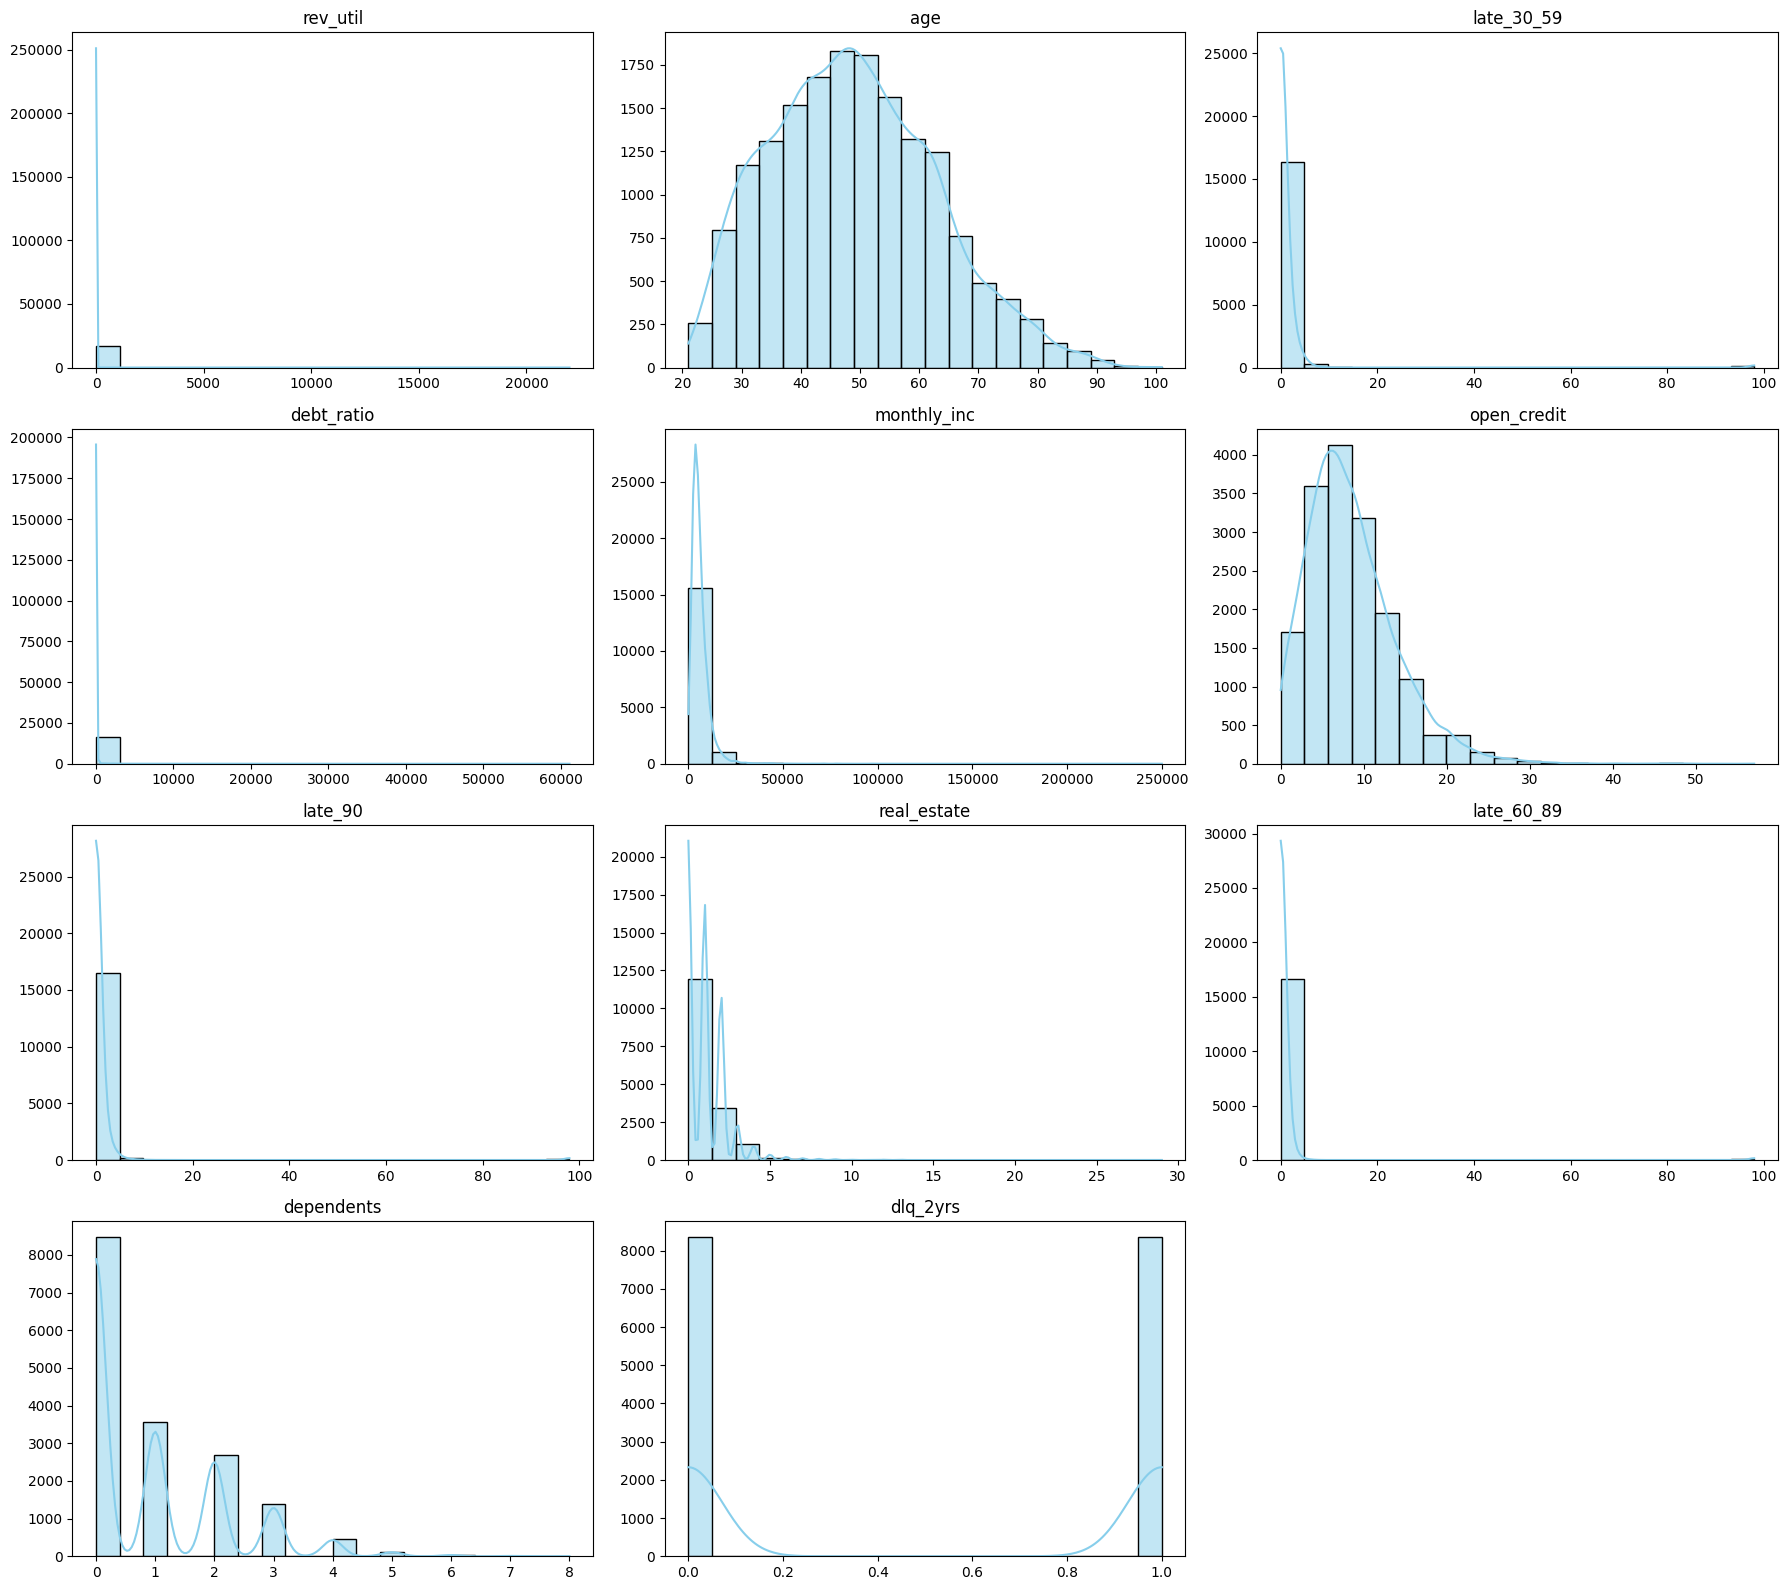

In [43]:
numeric_cols = df.select_dtypes(include="number").columns
n_cols = 3  
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation Analysis

The correlation matrix heatmap reveals the following patterns and relationships:

**Strong Correlations (|p| > 0.7)**:
1. Late Payment Variables:
   - `late_30_59` ↔ `late_60_89`: ρ = 0.99
   - `late_60_89` ↔ `late_90`: ρ = 0.99
   - `late_30_59` ↔ `late_90`: ρ = 0.98
   - Suggests progression of payment difficulties
   - High multicollinearity risk for modeling

2. Credit Lines:
   - `real_estate` ↔ `open_credit`: ρ = 0.47
   - More real estate loans associated with more credit lines
   - May indicate higher creditworthiness

**Default Risk Correlations**:
1. Positive Correlations with `dlq_2yrs`:
   - `late_30_59`: ρ = 0.12 (strongest predictor)
   - `late_90`: ρ = 0.11 (second strongest predictor)

2. Negative Correlations with `dlq_2yrs`:
   - `age`: ρ = -0.21
   - `monthly_inc`: ρ = -0.082
   - Other features have little to no correlation with `dlq_2yrs`

**Feature Engineering Implications**:
1. Combine late payment variables to address multicollinearity
2. Create interaction terms between:
   - `rev_util` and `debt_ratio`
   - `monthly_inc` and `debt_ratio`
3. Consider age brackets rather than continuous age
4. Create composite credit profile features

These relationships suggest both direct risk factors (utilization, late payments) and protective factors (age, income, assets).


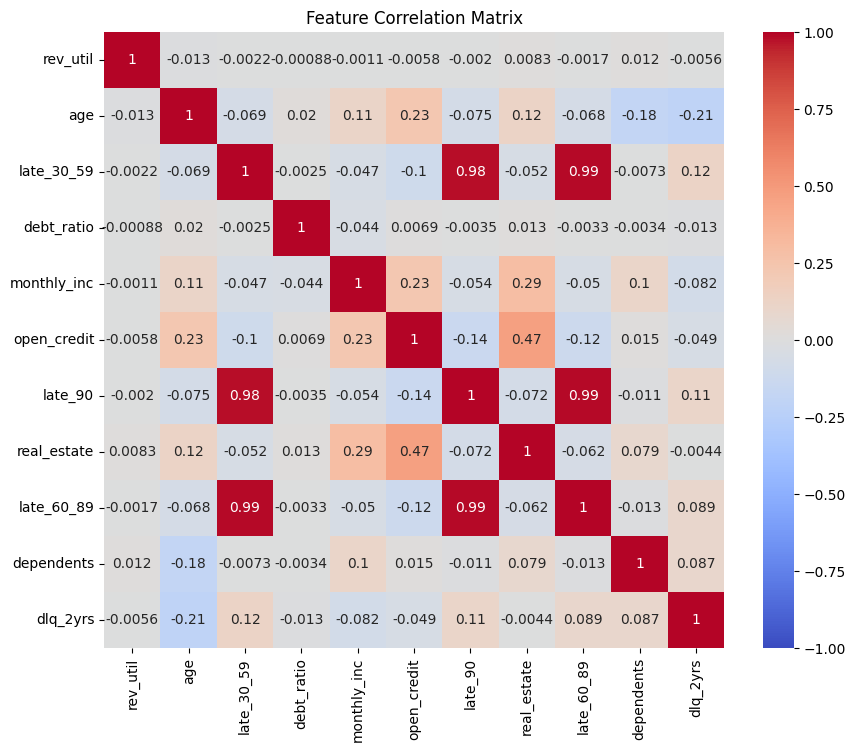

In [36]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### Default vs Non-Default Comparison

The KDE plots reveal clear separations between defaulters and non-defaulters:

**Financial Health Indicators**:

1. Revolving Utilization (`rev_util`):
   - Defaulters: Heavy concentration above 80% utilization
   - Non-defaulters: Most below 50% utilization
   - Clear separation suggests strong predictive power
   - Potential threshold effect around 70-80%

2. Debt Ratio:
   - Defaulters: Higher concentration above 50% DTI
   - Non-defaulters: Peak around 30% DTI
   - Substantial overlap in middle ranges
   - Extreme values more common in default group

3. Monthly Income:
   - Defaulters: Mode around $3,000-4,000
   - Non-defaulters: Mode around $5,000-6,000
   - Significant overlap but clear shift
   - Income effect stronger at higher ranges

**Payment History**:

4. Late Payments (30-59, 60-89, 90+ days):
   - Defaulters: Much higher probability of past late payments
   - Non-defaulters: Concentrated at zero
   - Pattern strengthens with payment lateness
   - Strong evidence of payment history importance

**Demographic and Credit Profile**:

5. Age Distribution:
   - Defaulters: Peak around 35-40 years
   - Non-defaulters: Peak around 50-55 years
   - Clear age gradient in default risk
   - Suggests age-specific risk strategies

6. Credit Lines:
   - Defaulters: Fewer open credit lines
   - Non-defaulters: More diversified credit
   - Relationship possibly confounded with age/income

**Risk Assessment Implications**:
1. High utilization (>80%) is a strong red flag
2. Age and income provide protective effects
3. Any late payment history significantly increases risk
4. Multiple credit lines may indicate stability
5. Consider interaction effects in modeling

**Density**
   - Depend on:
      1. How spread out the data is (visualize a scatter plot)
      2. How concentrated the values are in certain ranges
      3. The total area under a curve is always 1

   `The more spread out the data is, the smaller density is. Density is NOT a probability, its just explaining how spread out the data is`
   
   (e.g) monthly_income:
      - Ranges from 0-250,000 (pre-processing), data is very spread out since the range is high, then the density must be very small [0.0000, 0.00014]

   (e.g) dependants:
      - Ranges from 0-8 (pre-processing), data is less spread out since range is low, then the overall density is high because the range is [0, 8]


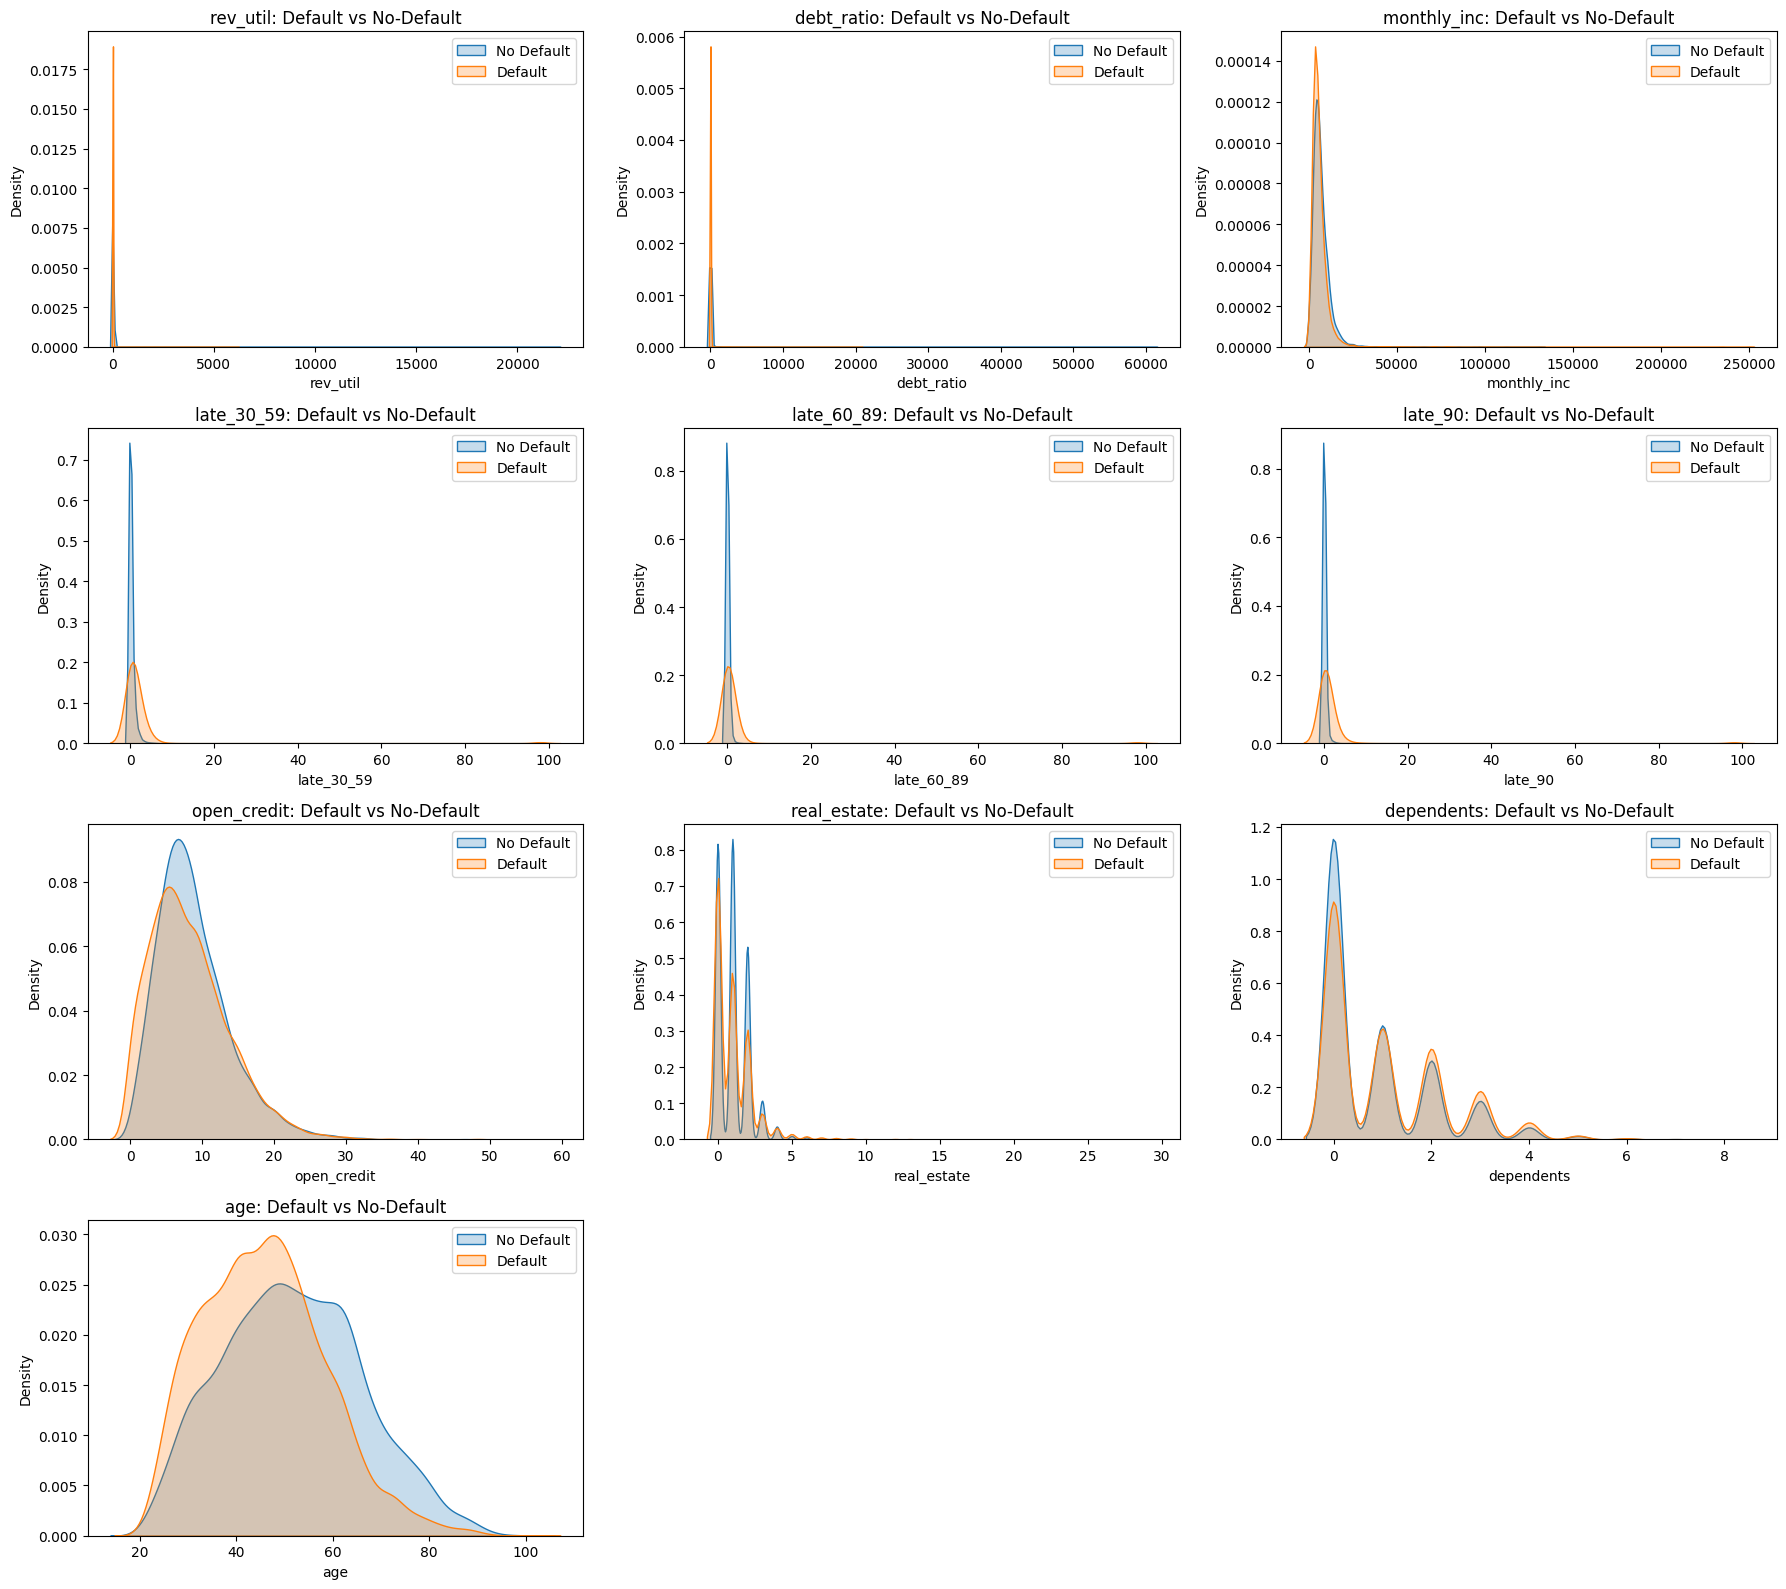

In [ ]:

features = ["rev_util", "debt_ratio", "monthly_inc",
            "late_30_59", "late_60_89", "late_90",
            "open_credit", "real_estate", "dependents", "age"]

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs == 0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs == 1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(f"{col}: Default vs No-Default")
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

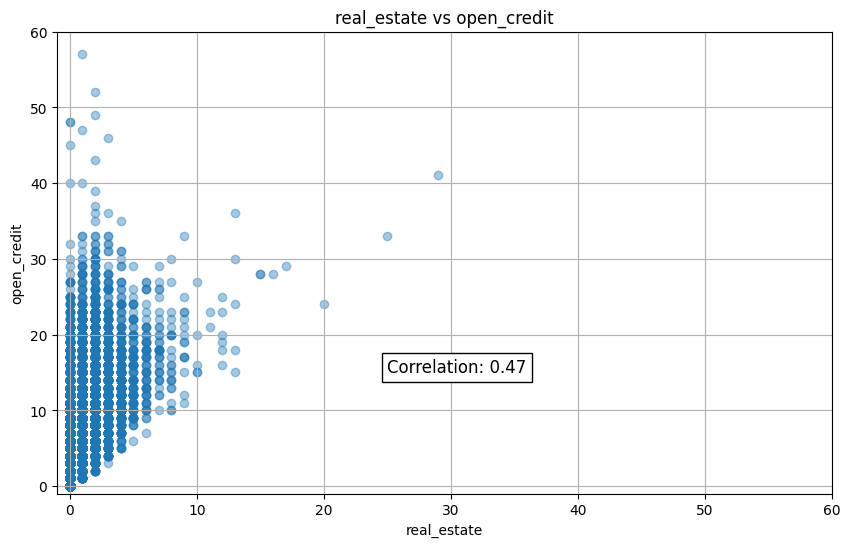

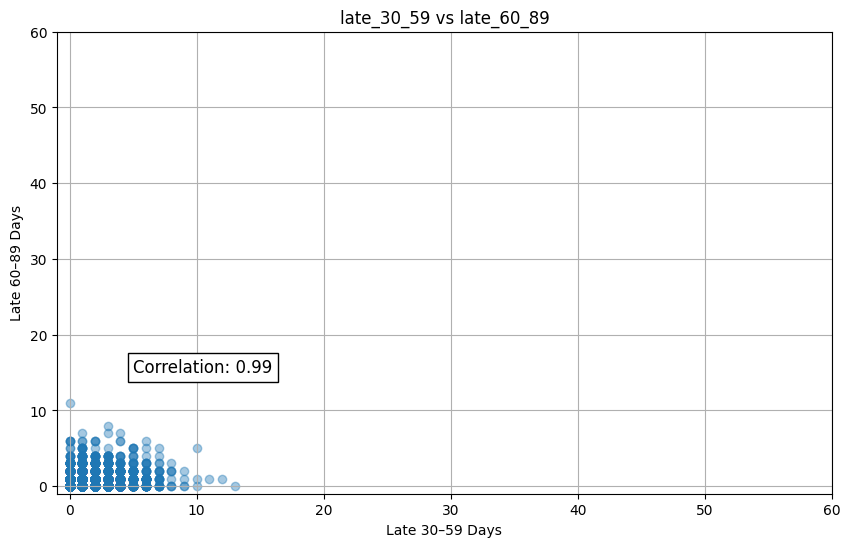

In [60]:
# real_estate vs open_credit
plt.figure(figsize=(10, 6))
plt.scatter(df["real_estate"], df["open_credit"], alpha=0.4)
plt.xlabel("real_estate")
plt.ylabel("open_credit")
plt.title("real_estate vs open_credit")

corr = df["real_estate"].corr(df["open_credit"])
plt.text(25, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()

# late_30_59 vs late_60_89
plt.figure(figsize=(10, 6))
plt.scatter(df["late_30_59"], df["late_60_89"], alpha=0.4)
plt.xlabel("Late 30–59 Days")
plt.ylabel("Late 60–89 Days")
plt.title("late_30_59 vs late_60_89")

corr = df["late_30_59"].corr(df["late_60_89"])
plt.text(5, 15, f"Correlation: {corr:.2f}", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
plt.xlim(-1, 60)
plt.ylim(-1, 60)
plt.grid(True)
plt.show()


### Feature Engineering and Variable Transformation

Based on our comprehensive analysis, we implement several strategic transformations:

**1. Payment History Consolidation**:
- Created `total_late` = sum of all late payment variables
  - Addresses high multicollinearity (ρ > 0.9)
  - Captures overall payment reliability
  - Reduces dimensionality while preserving information

**2. Relative Payment Performance**:
- Introduced `late_ratio` = total_late / open_credit
  - Normalizes late payments by credit exposure
  - Handles scale differences between borrowers
  - More interpretable than raw counts

**3. Outlier Treatment**:
- Capped `debt_ratio` at 99th percentile 
  - Original range: 0% to ~61,000%
  - Removes unrealistic values for better model

- Capped `monthly_inc` at 99th percentile 
  - Original range: $0 to $250,000
  - Reduces impact of extreme outliers for better model

**4. Age Stratification**:
Created meaningful age groups:
- 20-29: Early career (highest risk)
- 30-44: Career development
- 45-59: Peak earning years
- 60-79: Pre/early retirement
- 80+: Retirement (lowest risk)

Default rates show clear age gradient:
- 20-29: 62.6% default rate
- 30-44: 57.6%
- 45-59: 50.4%
- 60-79: 31.8%
- 80+: 25.4%

**5. Log Transformations**:
Applied log1p to heavily skewed variables:
- `rev_util`
- `debt_ratio`
- `monthly_inc`
- `total_late`
- `late_ratio`


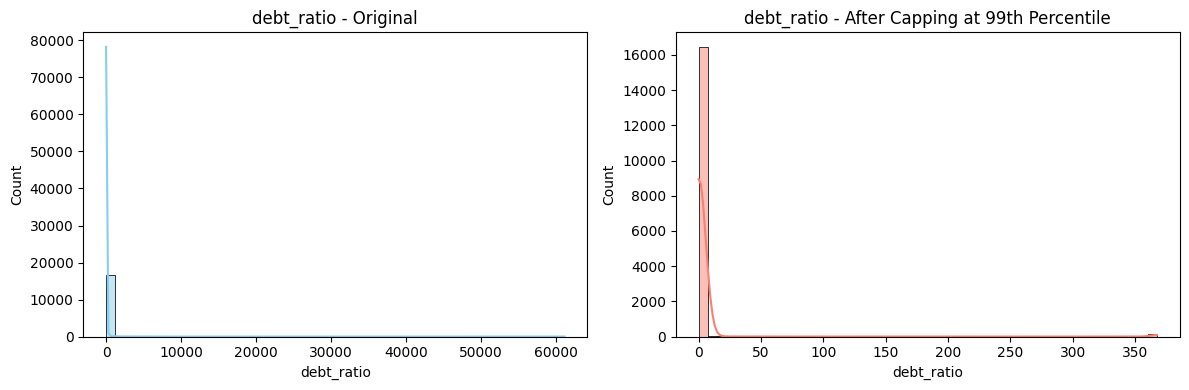

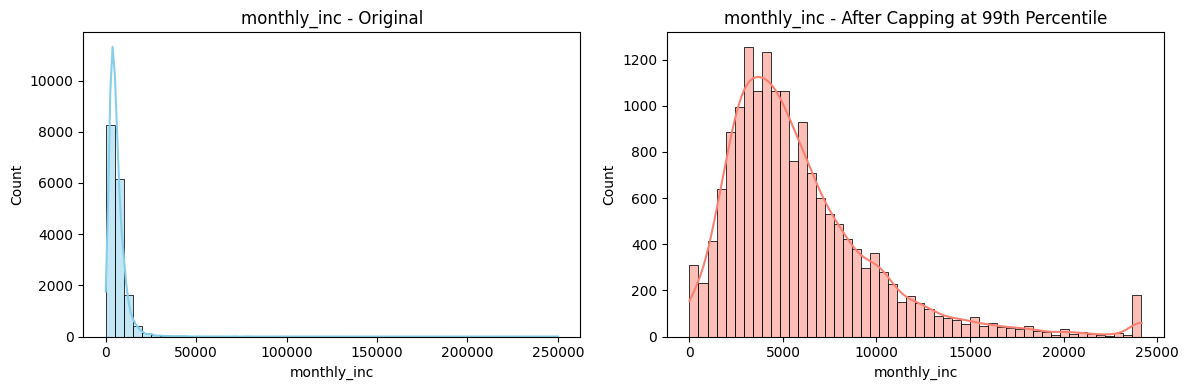

C:\Users\max3l\AppData\Local\Temp\ipykernel_169596\1923588752.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age_group", data=df, palette="muted", legend=False)


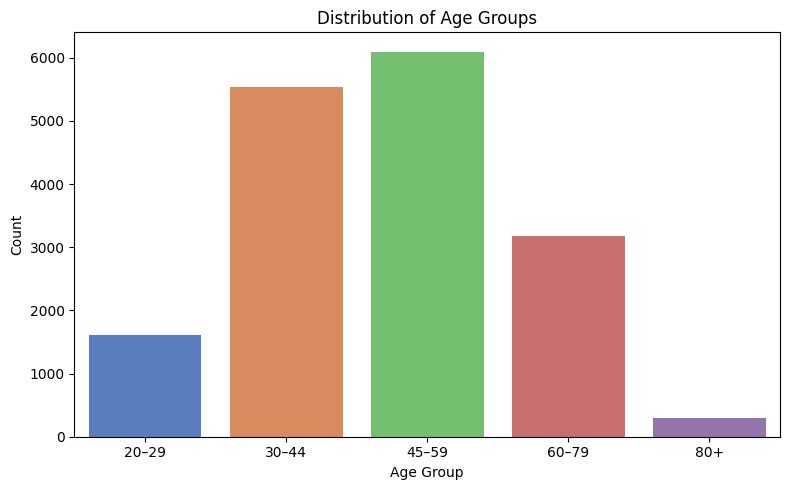

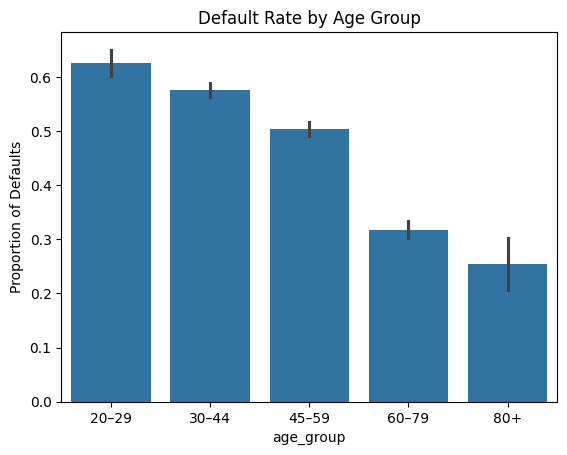

age_group
20–29    0.625622
30–44    0.576375
45–59    0.503608
60–79    0.318196
80+      0.254296
Name: dlq_2yrs, dtype: float64


C:\Users\max3l\AppData\Local\Temp\ipykernel_169596\1923588752.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate = df.groupby("age_group")["dlq_2yrs"].mean()


In [ ]:
df["total_late"] = df["late_30_59"] + df["late_60_89"] + df["late_90"]
df["late_ratio"] = df["total_late"] / df["open_credit"]
df["late_ratio"].fillna(0)

for col in ["debt_ratio", "monthly_inc"]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(df[col], bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Original")

    upper = df[col].quantile(0.99)
    capped = df[col].clip(upper=upper)
    sns.histplot(capped, bins=50, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title(f"{col} - After Capping at 99th Percentile")

    plt.tight_layout()
    plt.show()

bins = [20, 30, 45, 60, 80, 100]
labels = ["20–29", "30–44", "45–59", "60–79", "80+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

plt.figure(figsize=(8, 5))
sns.countplot(x="age_group", data=df, palette="muted", legend=False)
plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

sns.barplot(x="age_group", y="dlq_2yrs", data=df)
plt.title("Default Rate by Age Group")
plt.ylabel("Proportion of Defaults")
plt.show()

default_rate = df.groupby("age_group")["dlq_2yrs"].mean()
print(default_rate)

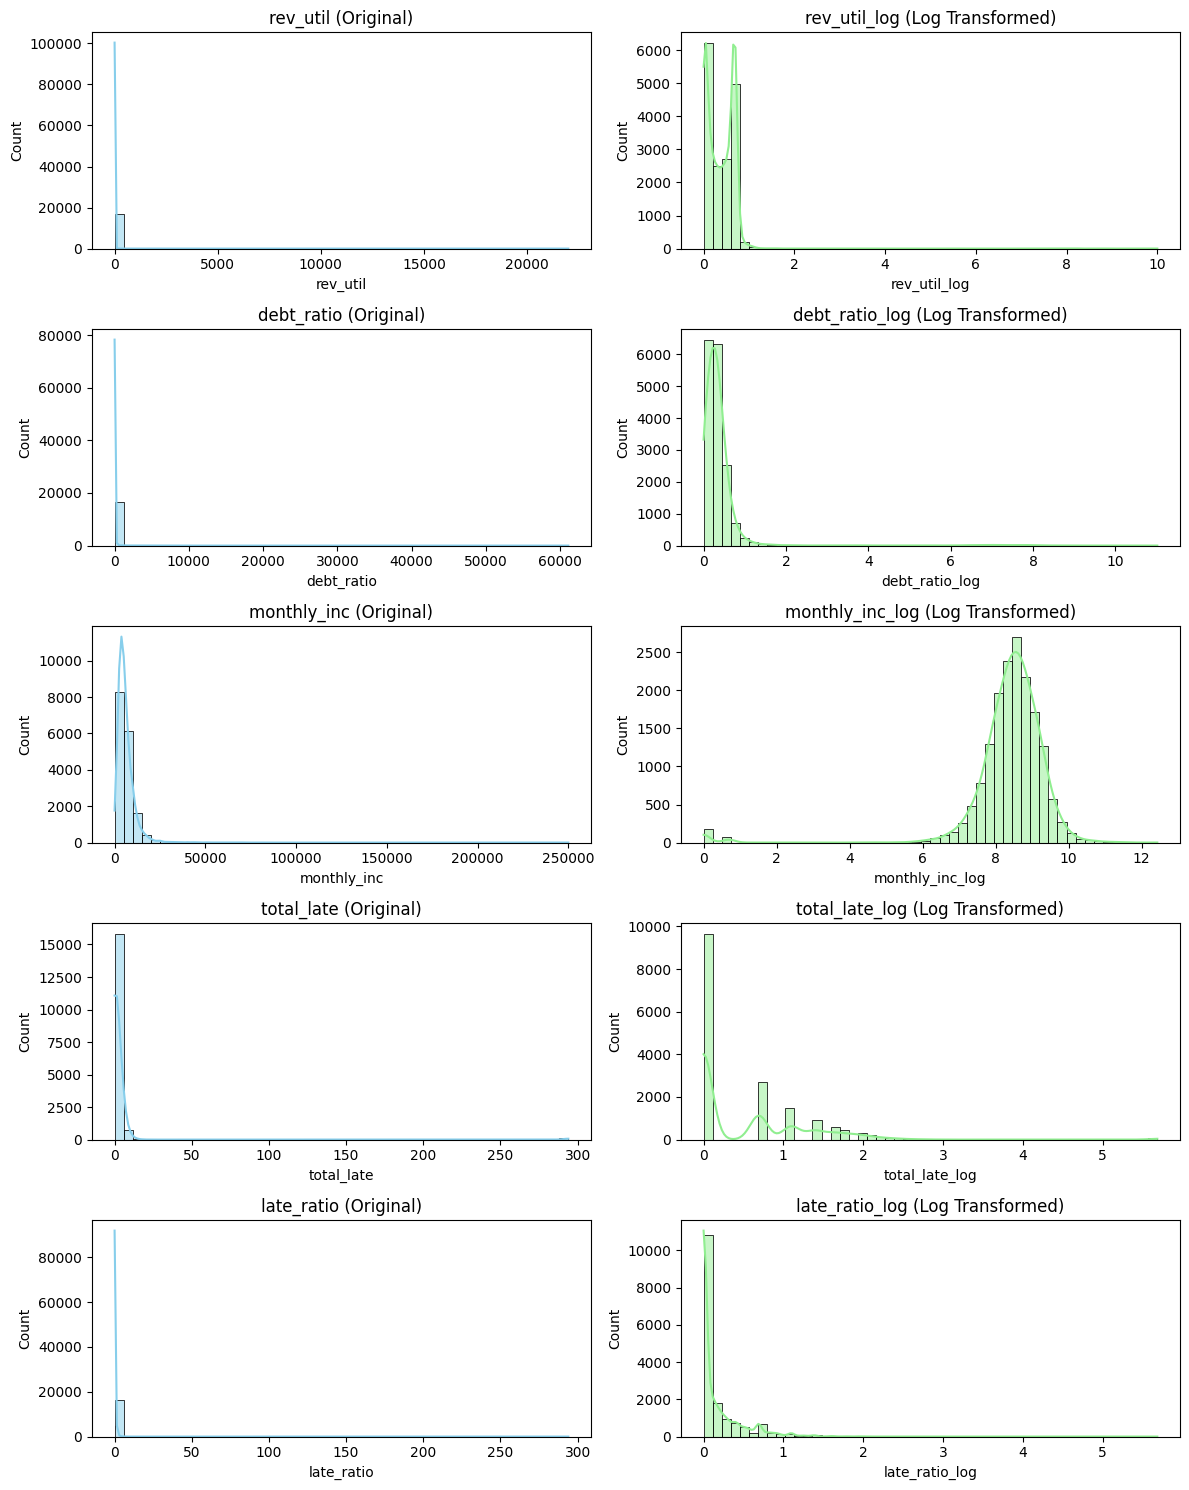

In [76]:
skewed = ["rev_util","debt_ratio","monthly_inc","total_late","late_ratio"]
for col in skewed:
    df[col + "_log"] = np.log1p(df[col])

n_cols = 2
n_rows = len(skewed)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

for i, col in enumerate(skewed):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f"{col} (Original)")
    
    sns.histplot(df[col + "_log"], bins=50, kde=True, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"{col}_log (Log Transformed)")

plt.tight_layout()
plt.show()



### Final Feature Analysis After Transformations

The visualization of original vs. transformed features reveals significant improvements:

**1. Distribution Improvements**:
- **Original Features**:
  - Extreme right skew in financial variables
  - Large gaps between median and mean
  - Difficult to visualize relationships
  - Outliers dominating scales

- **Log-Transformed Features**:
  - More symmetric distributions
  - Better spread of data points

**2. Default Risk Separation**:
- **rev_util_log**:
  - Clearer separation between risk groups
  - More uniform spread 
  - Threshold effects more visible

- **debt_ratio_log**:
  - Reduced impact of extreme outliers
  - More interpretable relationship with default
  - Preserved important risk signals

- **monthly_inc_log**:
  - More normal distribution
  - Clearer income-risk relationship
  - Improved comparison across income levels (more standardized)

**3. Engineered Features Performance**:
- **total_late_log**:
  - Vombines payment history
  - Handles zero-inflation better
  - More stable for modeling

- **late_ratio**:
  - Clear risk stratification

**4. Final Correlation Structure**:
- Reduced multicollinearity
- Preserved key relationships
- Better feature independence
- Improved model stability potential

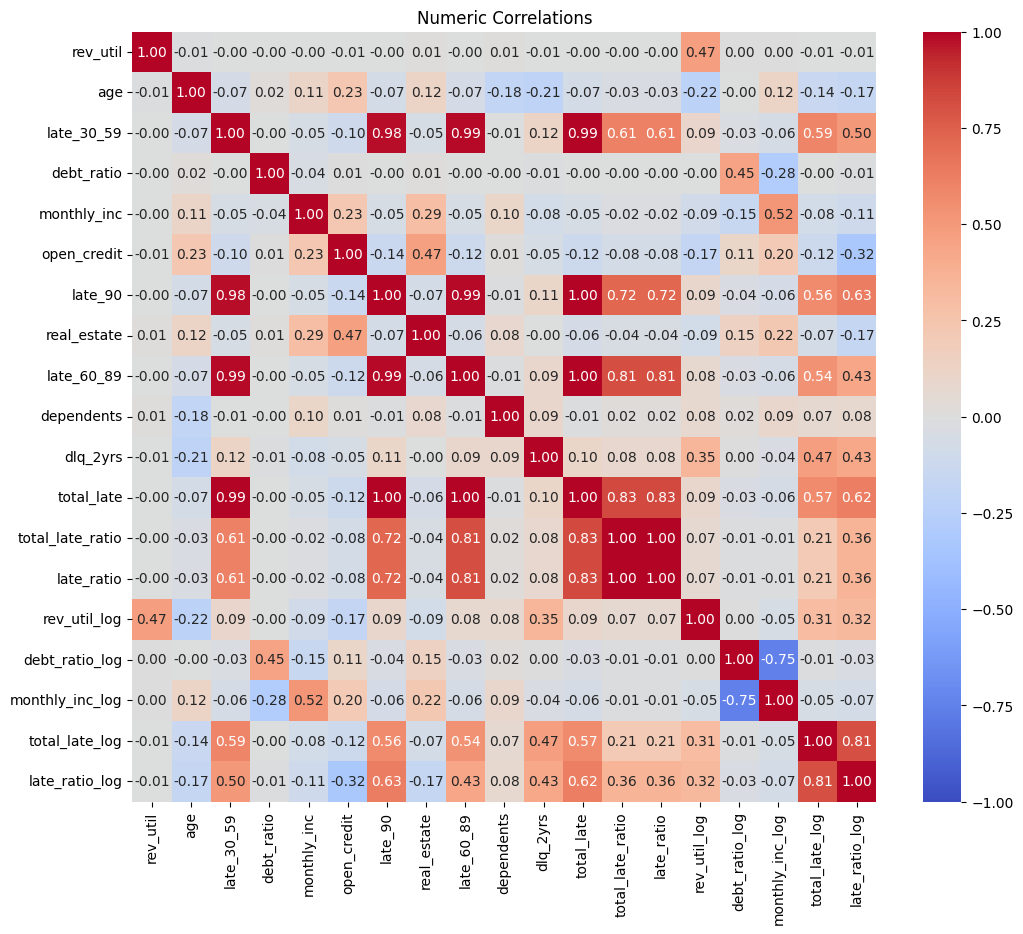

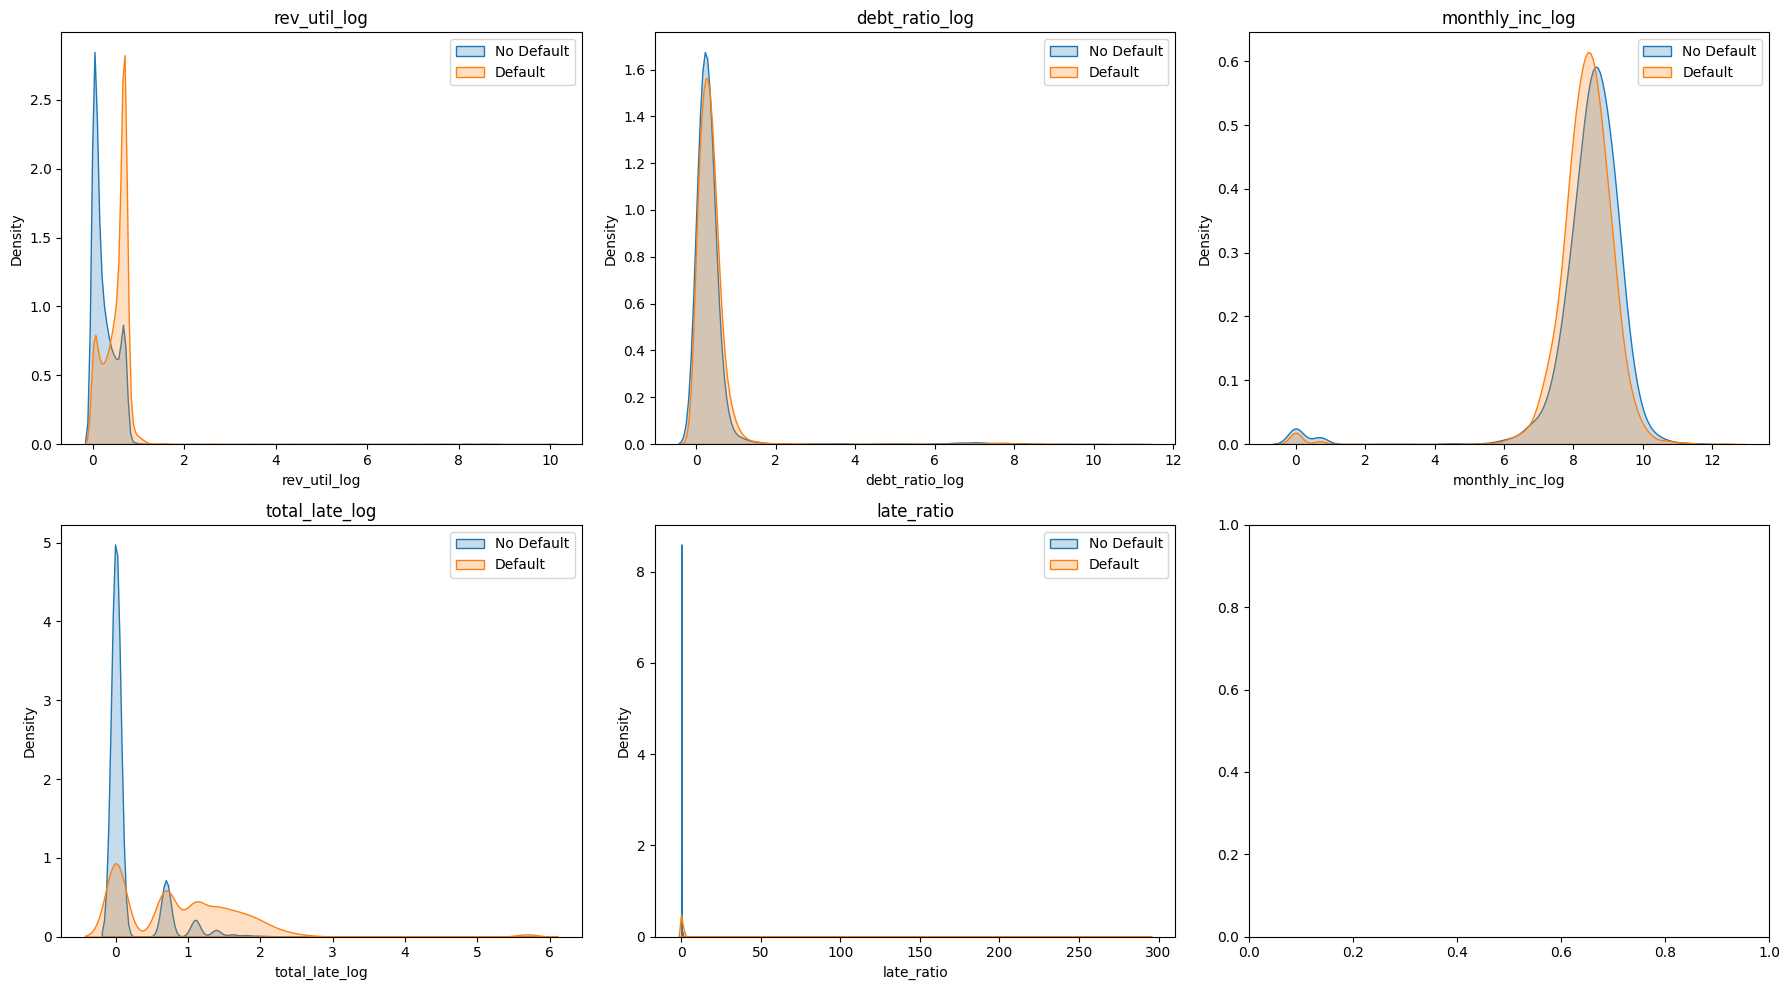

In [79]:
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include="number").corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Numeric Correlations")
plt.show()

features = ["rev_util_log","debt_ratio_log","monthly_inc_log","total_late_log","late_ratio"]
fig, axes = plt.subplots(2, 3, figsize=(18,10)); axes = axes.flatten()
for i, col in enumerate(features):
    sns.kdeplot(df[df.dlq_2yrs==0][col], label="No Default", fill=True, ax=axes[i])
    sns.kdeplot(df[df.dlq_2yrs==1][col], label="Default", fill=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()
